In [1]:
from sklearn.ensemble import RandomForestRegressor
import os
import torch
from torch.utils.data import Dataset,DataLoader
from torchmetrics import MeanAbsoluteError, MeanSquaredError
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, WeightedRandomSampler
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score
from torchmetrics import MeanAbsoluteError, MeanSquaredError

In [2]:
# read in data 
pathData_train = '/pfs/data5/home/kit/lti/rk3078/JupyterNotebooks/data/dataset01_train.h5'
db_train = pd.read_hdf(pathData_train, 'df')
pathData_test = '/pfs/data5/home/kit/lti/rk3078/JupyterNotebooks/data/dataset01_test.h5'
db_test = pd.read_hdf(pathData_test, 'df')
pathData_all = '/pfs/data5/home/kit/lti/rk3078/JupyterNotebooks/data/dataset01_all.h5'
db_all = pd.read_hdf(pathData_all, 'df')

In [3]:
for column in ["meanThickness","stdThickness","rmsThickness"]:
    db_train[column] = pd.to_numeric(db_train[column])
    db_test[column] = pd.to_numeric(db_test[column])
    db_all[column] = pd.to_numeric(db_all[column])

# Correlation Coefficients

In [4]:
paramsList=["maxValueLP725","endPLLP725"]
labelList=["pce_backward","voc_backward","jsc_backward","ff_backward","meanThickness"]
for label in labelList:
    for param in paramsList:
        print(label,param)
        print(round(np.corrcoef(db_train[label], db_train[param])[0,1],3))

pce_backward maxValueLP725
0.327
pce_backward endPLLP725
-0.011
voc_backward maxValueLP725
0.026
voc_backward endPLLP725
0.117
jsc_backward maxValueLP725
0.169
jsc_backward endPLLP725
-0.015
ff_backward maxValueLP725
0.408
ff_backward endPLLP725
-0.069
meanThickness maxValueLP725
-0.608
meanThickness endPLLP725
0.609


# KNN regressor

pce_backward
splits:
0 baseline: 2.2372 mae: 2.3128 delta: 0.0338 for K= 7
1 baseline: 1.6022 mae: 0.9253 delta: -0.4225 for K= 14
2 baseline: 1.7117 mae: 1.4511 delta: -0.1522 for K= 7
3 baseline: 2.0249 mae: 1.4138 delta: -0.3018 for K= 5
4 baseline: 1.8622 mae: 1.5699 delta: -0.157 for K= 15


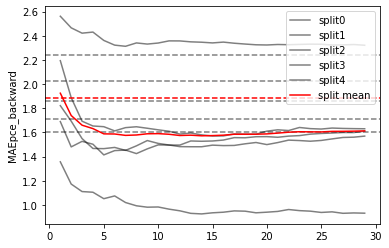

k_test: 14
mean over splits:
baseline: 1.8876 mae: 1.5718 delta: -0.1673
test set:
baseline: 1.9087 mae: 1.5323 delta: -0.1972


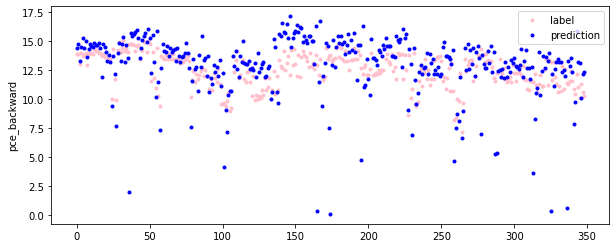

-----------------------------------------------------------------------
voc_backward
splits:
0 baseline: 0.0456 mae: 0.0436 delta: -0.0432 for K= 22
1 baseline: 0.013 mae: 0.0146 delta: 0.1192 for K= 26
2 baseline: 0.0204 mae: 0.0176 delta: -0.1379 for K= 21
3 baseline: 0.0348 mae: 0.0265 delta: -0.2384 for K= 1


In [ ]:
useSignal="LP725"

for useLabel in ["pce_backward", "voc_backward", "jsc_backward", "ff_backward", "meanThickness","stdThickness","rmsThickness"]:

    fig2, ax2 = plt.subplots()
    mae_all_folds=[]
    mae_all_folds_baseline=[]
    print(useLabel)
    print("splits:")
    
    for foldNumber in range(5):
        trainset=db_train[db_train["foldNo"]!=foldNumber].copy()
        validset=db_train[db_train["foldNo"]==foldNumber].copy()
        #print(len(trainset),len(validset))
                
        x_train=pd.DataFrame(data=np.vstack(trainset[useSignal].to_numpy()))
        y_train=trainset[useLabel]
        
        x_valid=pd.DataFrame(data=np.vstack(validset[useSignal].to_numpy()))
        y_valid=validset[useLabel]
        
        mae_current_fold=[]
  
        k_list = np.arange(1, 30)
        for k in k_list:
            knn = KNeighborsRegressor(k,weights='uniform')
            knn.fit(x_train, y_train)
            predictions = knn.predict(x_valid)
            
            mae = MeanAbsoluteError()        
            mae_current_fold.append(mae(torch.from_numpy(predictions), torch.from_numpy(np.array(y_valid))))



        baselineMAE=mae(torch.from_numpy(np.array([y_train.mean()]*len(y_valid))), torch.from_numpy(np.array(y_valid)))
        mae_all_folds.append(mae_current_fold)
        mae_all_folds_baseline.append(baselineMAE)
  
        ax2.plot(k_list, mae_current_fold, label='split'+str(foldNumber), color='black',alpha=0.5)
        ax2.axhline(y=baselineMAE, color="k", linestyle="dashed",alpha=0.5)
        ax2.legend()
        

        print(foldNumber, "baseline:", round(baselineMAE.item(),4), "mae:",round(mae_current_fold[np.argmin(mae_current_fold)].item(),4), 
              "delta:",round(mae_current_fold[np.argmin(mae_current_fold)].item()/baselineMAE.item()-1,4), "for K=", np.argmin(mae_current_fold)+1)
    
    ax2.plot(k_list, np.mean(np.array(mae_all_folds),axis=0), label='split mean', color='r')
    ax2.axhline(y=np.mean(mae_all_folds_baseline), color="r", linestyle="dashed")
    ax2.set_ylabel("MAE" + str(useLabel))
    ax2.legend()  
    plt.show()
    
    indMin=np.argmin(np.mean(np.array(mae_all_folds),axis=0))
    print("k_test:", indMin+1)
    print("mean over splits:")
    print("baseline:",round(np.mean(mae_all_folds_baseline),4), "mae:",round(np.mean(np.array(mae_all_folds),axis=0)[indMin],4), "delta:",round(np.mean(np.array(mae_all_folds),axis=0)[indMin]/np.mean(mae_all_folds_baseline)-1,4))
    
    #############################################
    
    k_test=indMin+1
    
    x_train=pd.DataFrame(data=np.vstack(db_train[useSignal].to_numpy()))
    y_train=db_train[useLabel]
    
    x_test=pd.DataFrame(data=np.vstack(db_test[useSignal].to_numpy()))
    y_test=db_test[useLabel]
    

            
    knn = KNeighborsRegressor(k_test)
    knn.fit(x_train, y_train)
    predictions = knn.predict(x_test)


    mae = MeanAbsoluteError()        
    mae_test=mae(torch.from_numpy(predictions), torch.from_numpy(np.array(y_test)))
    baselineMAE_test=mae(torch.from_numpy(np.array([y_train.mean()]*len(y_test))), torch.from_numpy(np.array(y_test)))

    print("test set:")
    print("baseline:",round(baselineMAE_test.item(),4),"mae:",round(mae_test.item(),4), "delta:",round(mae_test.item()/baselineMAE_test.item()-1,4))

    
    plt.figure(figsize=(10, 4))
    plt.plot(range(len(predictions)),predictions, ".",color="pink", label="label")
    plt.plot(range(len(predictions)),y_test, ".",color="blue", label="prediction")
    plt.axis("tight")
    plt.ylabel(useLabel)
    plt.legend()
    plt.show()      
    print("-----------------------------------------------------------------------")
    
    
    
    #break